# 01 - Data Preprocessing

GOAL: Create Normal Training Dataset

## A - Libraries

In [10]:
import pandas as pd
import numpy as np
import os

## B - Retrieving Separate Datasets

In [37]:
def get_cohort_samples(cohort_name):
    # Get the xls file
    xls = pd.ExcelFile(f'data/PreprocessedData_{cohort_name}.xlsx')

    # Get the dataframes for the preprocessed metabolomics data
    n = xls.parse("metabo_imputed_filtered_Normal")

    # Get list of metabolites
    n_met_list = n["Unnamed: 0"].to_list()

    # Get list of sample IDs
    n_sample_list = n.columns.to_list()[1:]

    # Set Index to metabolite names, drop "Unnamed: 0" column
    n.set_index("Unnamed: 0", inplace=True)

    return {
        "sample_list"   : n_sample_list,
        "met_list"      : n_met_list,
        "matrix"        : n
    }

cohorts = {
    "BRCA1": None,
    "COAD": None,
    "ccRCC3": None,
    "ccRCC4": None,
    "GBM": None,
    "HurthleCC": None,
    "PDAC": None,
    "PRAD": None,
}

for c in cohorts.keys():
    cohorts[c] = get_cohort_samples(c)

In [56]:
met_union_set = set()
sample_list_all = []
for c in cohorts.keys():
    met_union_set    |= set(cohorts[c]["met_list"])
    sample_list_all += cohorts[c]["sample_list"]

met_list_all    = list(met_union_set)
met_list_all.sort()


In [ ]:
def construct_training_dataframe(met_list_all, sample_list_all, cohorts):
    df = pd.DataFrame(np.zeros(shape=(len(met_list_all), len(sample_list_all))),
                      index=met_list_all,
                      columns=sample_list_all)
    
    for c in cohorts:
        for m in cohorts[c]['met_list']:
            for s in cohorts[c]['sample_list']:
                df.loc[m][s] = cohorts[c]["matrix"].loc[m][s]
    return df

df = construct_training_dataframe(met_list_all, sample_list_all, cohorts)

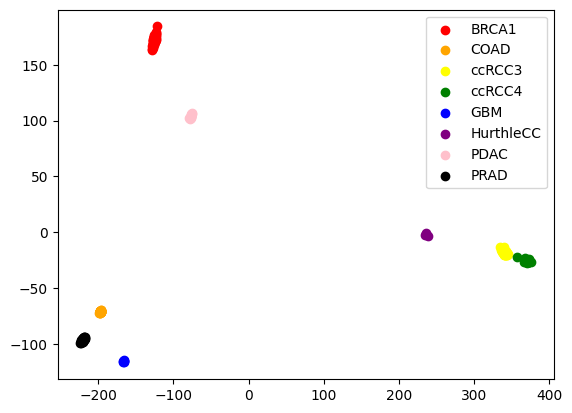

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
np_df = df.T.to_numpy()
pca_model = PCA(n_components=2)
results = pca_model.fit_transform(np_df)

plt.scatter(results[0:47,0], results[0:47, 1], c='red'          ,label="BRCA1")
plt.scatter(results[47:86,0], results[47:86, 1], c='orange'     ,label="COAD")
plt.scatter(results[86:133,0], results[86:133, 1], c='yellow'   ,label="ccRCC3")
plt.scatter(results[133:157,0], results[133:157, 1], c='green'  ,label="ccRCC4")
plt.scatter(results[157:163,0], results[157:163, 1], c='blue'   ,label="GBM")
plt.scatter(results[163:166,0], results[163:166, 1], c='purple' ,label="HurthleCC")
plt.scatter(results[166:178,0], results[166:178, 1], c='pink'   ,label="PDAC")
plt.scatter(results[178:224,0], results[178:224, 1], c='black'  ,label="PRAD")
plt.legend()
plt.show()

In [33]:
# Get the xls file
cohort_name = "PRAD"
xls = pd.ExcelFile(f'data/PreprocessedData_{cohort_name}.xlsx')

# Get the dataframes for the preprocessed metabolomics data
# t = xls.parse("metabo_imputed_filtered_Tumor")
n = xls.parse("metabo_imputed_filtered_Normal")

# Replace IDs of the dataframes
# t.rename({"Unnamed: 0": "t_met"}, inplace=True, axis=1)
n.rename({"Unnamed: 0": "n_met"}, inplace=True, axis=1)

# Get list of metabolites
# t_list = t["t_met"].to_list()
n_list = n["n_met"].to_list()
# met_list = list(set(t_list) | set(n_list))

# Create a dictionary of the metabolite names and HMDB IDs
###########
# 05/25/25 - Eliminated HMDB IDs use because only 72% of the features have HMDB IDs across all cohorts
# For Reference:
#           TOTAL_FEATURES  TOTAL_FEATURES_WITH_HMDB_IDS
# BRCA1     324             215
# COAD      160	            141
# ccRCC3    727	            551
# ccRCC4    951	            701
# GBM       704	            357
# HurthleCC 668	            523
# PDAC      325	            279
# PRAD      382	            320
###########
# metanno = xls.parse("metanno")
# metanno_dict = metanno.set_index("H_name")["H_HMDB"].to_dict()
# hmdb_list = set(metanno.loc[metanno["H_name"].isin(n_list)]["H_HMDB"].tolist()


# Get dataframe with only sorted shared metabolites
# t_shared = t[t["t_met"].isin(met_list)]
# t_shared.sort_values("t_met", ignore_index=True, inplace=True)
# n_shared = n[n["n_met"].isin(met_list)]
# n_shared.sort_values("n_met", ignore_index=True, inplace=True)
# merged = pd.concat([t_shared, n_shared], axis=1)

# n = n.set_index(n["n_met"])
n_no_labels = n.drop(labels=['n_met'], axis=1)
print(n.set_index("n_met"))

                              DFCI-00530  DFCI-00532  DFCI-00536  DFCI-00540  \
n_met                                                                          
1,2-propanediol                -3.145295   -1.874510    0.022213   -2.474979   
1,3-diaminopropane             -3.136273   -3.136273   -3.136273   -1.600155   
1,5-anhydroglucitol (1,5-AG)   -0.573711    0.179714   -0.596981   -0.660364   
1,7-dimethylurate               0.804077    0.465929   -0.288257    0.852950   
1-arachidonoyl-GPC (20:4n6)    -0.921294    1.793375    0.044667    0.247106   
...                                  ...         ...         ...         ...   
leucylleucine                  -1.565186   -1.565186   -1.565186   -1.565186   
piperine                       -2.578222   -2.578222   -2.578222   -2.578222   
saccharopine                   -1.902064   -1.902064   -1.902064   -1.902064   
theobromine                    -1.693003   -1.693003   -1.693003   -1.693003   
UDP-N-acetylglucosamine        -2.076153